In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 13.2MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=6d292590cf898c0a169cf809082855e4090beac3195fc359d15e15090ba358b3
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
!pip install arch

     |████████████████████████████████| 808kB 15.5MB/s 


In [ ]:
# Import necessary libraries: 

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm, t
from arch import arch_model

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Define functions that I need to work with data (download and preprocess):

# Define data downloader function: 

def stock_data_download(symbols, start_date, end_date):
  data_holder = dict()
  for idx in symbols:
    stock_data = yf.download(idx, start_date, end_date)
    data_holder[idx] = stock_data

  return data_holder

# Define data extractor function:

def stock_data_extract(symbols, col_name, data):
  data_holder = pd.DataFrame()
  for idx in symbols:
    data_point = data[idx][col_name]
    data_holder[idx] = data_point
  
  return data_holder

# Define stock data stat function: 

def stock_portfolio_returns(data, weights):
  returns = data.pct_change()
  returns = returns.dropna()
  mean_returns = returns.mean()
  cov_returns = returns.cov()
  returns['portfolio'] = returns.dot(weights)

  return returns, mean_returns, cov_returns

In [ ]:
# Download data: 

# Define parameters of the download: 

symbol = ['APPS', 'AMC', 'GME']
start_date = '2011-01-01'
end_date = '2021-06-25'

df = stock_data_download(symbol, start_date, end_date)
df_filter = stock_data_extract(symbol, 'Adj Close', df)
df_filter_returns = df_filter.pct_change().dropna()
df_filter_returns.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,APPS,AMC,GME
Date,,,
2013-12-19,-0.018939,0.031217,-0.001202
2013-12-20,-0.027027,0.009748,-0.012432
2013-12-23,0.087302,0.003049,0.025787
2013-12-24,0.014599,-0.010638,0.008907
2013-12-26,-0.028777,0.012801,-0.011967


In [ ]:
# get necessary data:
apps_ret = df_filter_returns['APPS']

# Define adn fit garch model:

am = arch_model(apps_ret, vol="Garch", p=1, o=0, q=1, dist="Normal")
res = am.fit(disp="off", last_obs="2018-12-31")

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001774. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [ ]:
# Use the defined model to forecast VaR:
forecasts = res.forecast(start="2019-1-1", reindex=False)
cond_mean = forecasts.mean["2019":]
cond_var = forecasts.variance["2019":]
q = am.distribution.ppf([0.01, 0.05]) #res.params[-2:])
print(q)

[-2.32634787 -1.64485363]


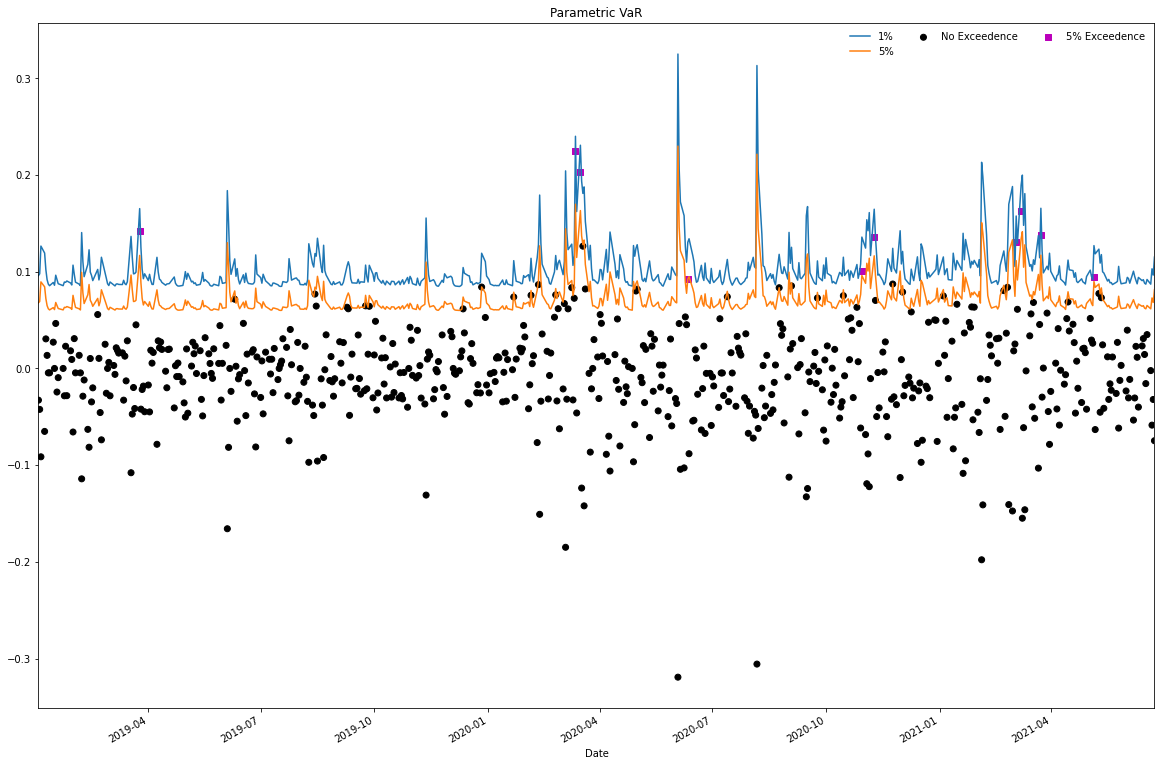

In [ ]:
# Plot the outcome:

value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=["1%", "5%"], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = apps_ret["2019":].copy()
rets_2018.name = "APPS Return"
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, "5%"]:
        c.append("#000000")
    elif rets_2018[idx] < -value_at_risk.loc[idx, "1%"]:
        c.append("#BB0000")
    else:
        c.append("#BB00BB")
c = np.array(c, dtype="object")
labels = {
    "#BB0000": "1% Exceedence",
    "#BB00BB": "5% Exceedence",
    "#000000": "No Exceedence",
}
markers = {"#BB0000": "x", "#BB00BB": "s", "#000000": "o"}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
      rets_2018.index[sel],
      -rets_2018.loc[sel],
      marker=markers[color],
      c=c[sel],
      label=labels[color],
    )

ax.set_title("Parametric VaR")
leg = ax.legend(frameon=False, ncol=3)
plt.rcParams['figure.figsize'] = [20, 14]